In [ ]:
!pip install torchmetrics

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.datasets import FashionMNIST
from torchmetrics import Accuracy
import matplotlib.pyplot as plt


In [ ]:
classes = [
    "airplane", "automobile", "bird", "cat",
    "deer", "dog", "frog", "horse", "ship",
    "truck"
]


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])


train_dataset = datasets.CIFAR10(root='./data',
                                      train=True, # Train dataset
                                      download=True,
                                      transform=transform_train
                                      )
test_dataset = datasets.CIFAR10(root='./data',
                                     train=False, # Test dataset
                                     download=True,
                                     transform=transform_test)

Image shape: torch.Size([3, 32, 32])


Text(0.5, 1.0, '6')

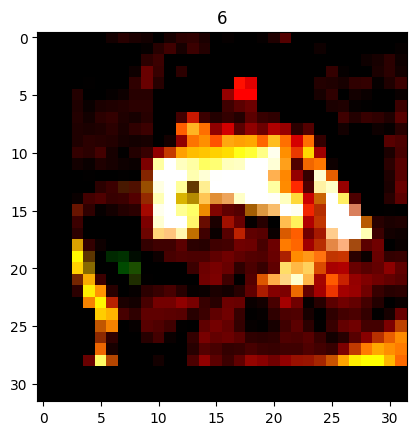

In [ ]:
image, label = train_dataset[0]
print(f"Image shape: {image.shape}")
# Reorder dimensions to (H, W, C)
plt.imshow(image.squeeze().permute(1, 2, 0))
plt.title(label)


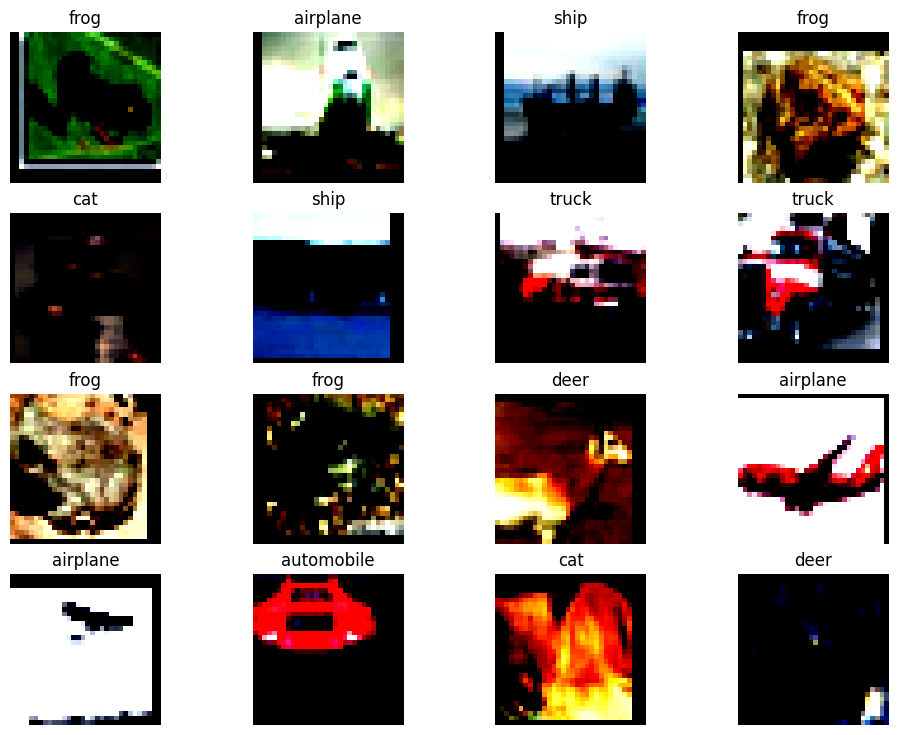

In [ ]:

figure = plt.figure(figsize=(12, 9))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()


In [ ]:
training_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                  batch_size=32,
                                                  shuffle=True,
                                                  drop_last=True)
testing_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                 batch_size=32,
                                                 shuffle=False,
                                                 drop_last=True)

print("DataLoaders created!")
print(f"Training batches: {len(training_dataloader)}")
print(f"Test batches: {len(testing_dataloader)}")


DataLoaders created!
Training batches: 1562
Test batches: 312


In [ ]:
# Let's see what our batches look like
for images, labels in training_dataloader:
    print(f"Batch shape: {images.shape}")  # [batch_size, 1, 28, 28]
    print(f"Labels shape: {labels.shape}") # [batch_size]
    print(f"First batch - Images: {images.shape}, Labels: {labels.shape}")

    break  # Just look at the first batch

next(iter(training_dataloader))[0].shape


Batch shape: torch.Size([32, 3, 32, 32])
Labels shape: torch.Size([32])
First batch - Images: torch.Size([32, 3, 32, 32]), Labels: torch.Size([32])


torch.Size([32, 3, 32, 32])

In [ ]:
import torch
from torch import nn


import torch.nn as nn

class ResidualBlock(nn.Module):
    """A basic residual block with two convolutional layers"""
    def __init__(self,
          in_channels,
                        out_channels,
                        stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,
                                out_channels,
                                kernel_size=3,
                                stride=stride,
                                padding=1,
                                bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,
                                out_channels,
                                kernel_size=3,
                                stride=1,
                                padding=1,
                                bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Skip connection adjustment if dimensions change
        self.skip_connection = nn.Sequential()
        # f stride != 1: The spatial dimensions (height/width) change
        #If in_channels != out_channels: The depth (number of channels) changes
        if stride != 1 or in_channels != out_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels,
                          out_channels,
                          kernel_size=1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        identity = self.skip_connection(identity)
        out += identity
        return self.relu(out)





In [ ]:
import torch
from torch import nn

class ResNetRGB(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.block1 = self._make_layer(32, 32, num_blocks=2, stride=1)
        self.block2 = self._make_layer(32, 64, num_blocks=2, stride=2)
        self.block3 = self._make_layer(64, 128, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

# Instantiate model
model = ResNetRGB().to(device)

#model(torch.randn(32, 1, 28, 28).to(device))


Using cuda


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)


In [ ]:
EPOCHS = 20
total_epoch_count = []

accuracy_mc = Accuracy(task="multiclass", num_classes=10).to(device)

total_training_loss, total_testing_loss = [], []
total_train_acc, total_test_acc = [], []
epoch_count = []

for epoch in range(EPOCHS):

    model.train()
    train_loss, train_acc = 0, 0
    accuracy_mc.reset()

    for X, y in training_dataloader:
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = logits.argmax(1)

        train_loss += loss.item()
        train_acc += accuracy_mc(y_pred, y)

    avg_train_loss = train_loss / len(training_dataloader)
    avg_train_acc = train_acc / len(training_dataloader)

    # ---- Testing ----
    model.eval()
    test_loss, test_acc = 0, 0
    accuracy_mc.reset()

    with torch.no_grad():
        for X, y in testing_dataloader:
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = loss_fn(logits, y)
            y_pred = logits.argmax(1)

            test_loss += loss.item()
            test_acc += accuracy_mc(y_pred, y)

    avg_test_loss = test_loss / len(testing_dataloader)
    avg_test_acc  = test_acc / len(testing_dataloader)

    total_training_loss.append(avg_train_loss)
    total_testing_loss.append(avg_test_loss)
    total_train_acc.append(avg_train_acc.item())
    total_test_acc.append(avg_test_acc.item())
    epoch_count.append(epoch)

    print(f"Epoch {epoch}: "
          f"train_loss={avg_train_loss:.3f} "
          f"train_acc={avg_train_acc:.3f} "
          f"test_loss={avg_test_loss:.3f} "
          f"test_acc={avg_test_acc:.3f}")


Epoch 0: train_loss=1.438 train_acc=0.473 test_loss=1.364 test_acc=0.522
Epoch 1: train_loss=0.984 train_acc=0.653 test_loss=0.895 test_acc=0.689
Epoch 2: train_loss=0.795 train_acc=0.724 test_loss=0.701 test_acc=0.758
Epoch 3: train_loss=0.677 train_acc=0.765 test_loss=0.719 test_acc=0.755
Epoch 4: train_loss=0.599 train_acc=0.793 test_loss=0.624 test_acc=0.794
Epoch 5: train_loss=0.541 train_acc=0.814 test_loss=0.523 test_acc=0.821
Epoch 6: train_loss=0.491 train_acc=0.831 test_loss=0.529 test_acc=0.825
Epoch 7: train_loss=0.454 train_acc=0.844 test_loss=0.446 test_acc=0.851
Epoch 8: train_loss=0.421 train_acc=0.854 test_loss=0.462 test_acc=0.849
Epoch 9: train_loss=0.389 train_acc=0.867 test_loss=0.436 test_acc=0.859


In [ ]:
figure = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(epoch_count, total_training_loss, label='Train Loss')
plt.plot(epoch_count, total_testing_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_count, total_train_acc, label='Train Accuracy')
plt.plot(epoch_count, total_test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

NameError: name 'plt' is not defined